# Analysis of training time vs. dimensionality of target distribution

In [706]:
import os
import sys
import pickle
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import OrderedDict

from utils.data_utils import calc_avg_vals_errors, block_resampling

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils.distributions import GMM
from mog_model import *
    
%autoreload 2

In [726]:
#colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
#markers = ['o', 's', 'x', 'v', 'h', '^', 'p', '<', 'd', '>', 'o']
#linestyles = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']
plt.style.use('/Users/saforem2/.config/matplotlib/'
               + 'stylelib/ggplot_sam.mplstyle')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.pad'] = 3.5
plt.rcParams['xtick.major.size'] = 3.5
plt.rcParams['xtick.major.width'] = 0.8
plt.rcParams['xtick.minor.pad'] = 3.4
plt.rcParams['xtick.minor.size'] = 2.0
plt.rcParams['xtick.minor.width'] = 0.6

%matplotlib notebook

In [367]:
def load_train_times(log_dir):
    info_dir = os.path.join(log_dir, 'run_info')
    train_times_file = os.path.join(info_dir, 'train_time.pkl')
    if os.path.isfile(train_times_file):
        with open(train_times_file, 'rb') as f:
            train_times_dict = pickle.load(f)
        return train_times_dict else:
        print(f"Unable to locate {train_times_file}, file does not exist.")

In [368]:
def split_dict(d):
    keys_arr = np.array(list(d.keys()))
    vals_arr = np.array(list(d.values()))
    return keys_arr, vals_arr

In [369]:
def average_duplicates(arr):
    _dict = {}
    for row in arr:
        key = int(row[0])
        avg = row[1]
        err = row[2]
        if key not in list(_dict.keys()):
            _dict[key] = [avg, err]
        else:  # dictionary already had a value assigned to this key
            avg1, err1 = _dict[key]
            new_avg = np.mean([avg, avg1])
            new_err = np.mean([err, err1])
            _dict[key] = [new_avg, new_err]
    new_arr = []
    for key, val in _dict.items():
        new_arr.append([int(key), *val])
    return np.array(new_arr)

## Load training time data from log dirs

In [737]:
log_dir = '../../timing_logs/'
log_dirs = [os.path.join(log_dir, i) 
            for i in os.listdir(log_dir) 
            if os.path.isdir(os.path.join(log_dir, i))
            and i != 'bad_logs']

tt_dict = {}
for d in log_dirs:
    name = d.split('/')[-1]
    name = name.split('_')
    name = f'tt_dim{name[2]}_{name[3]}'  # tt = train_times
    tt_dict[name] = load_train_times(d)

tt_diffs_dict = {}
tt_per_step_dict = {}
for key, val in tt_dict.items():
    tt_diffs_dict[key] = {}
    steps = np.array(list(val.keys()))
    dsteps = np.array(list(val.keys())[1:])
    times = np.array(list(val.values()))
    step_diffs = steps[1:] - steps[:-1]
    time_diffs = times[1:] - times[:-1]
    time_diffs_per_step = time_diffs / step_diffs
    tt_diffs_dict[key] = dict(zip(dsteps, diffs))
    tt_per_step_dict[key] = time_diffs_per_step
    
def split_key(key):
    s = key.split('_')
    dim = s[1].lstrip('dim')
    return dim

tt_diffs_dict = OrderedDict(sorted(tt_diffs_dict.items(), 
                                   key=lambda k: int(split_key(k[0]))))
tt_per_step_dict = OrderedDict(sorted(tt_per_step_dict.items(),
                                      key=lambda k: int(split_key(k[0]))))

In [792]:
tt_diffs_dict.keys()

odict_keys(['tt_dim2_339', 'tt_dim2_340', 'tt_dim5_384', 'tt_dim10_360', 'tt_dim10_359', 'tt_dim10_377', 'tt_dim15_379', 'tt_dim20_414', 'tt_dim20_386', 'tt_dim25_415', 'tt_dim25_387', 'tt_dim30_388', 'tt_dim30_416', 'tt_dim35_423', 'tt_dim35_421', 'tt_dim40_422', 'tt_dim45_419', 'tt_dim50_420', 'tt_dim75_429', 'tt_dim75_428', 'tt_dim80_433'])

In [795]:
(tt_diffs_dict['tt_dim15_379'][120000] - tt_diffs_dict['tt_dim15_379'][1000])/(60*60)

8.206219411955939

In [738]:
tt_per_step_arr = []
bad_dirs = []
for key, val in tt_per_step_dict.items():
    dimension = int(key.split('_')[1].lstrip('dim'))
    try:
        avg, err = calc_avg_vals_errors(val[10:], num_blocks=20)
    except ValueError:
        bad_dirs.append(key)
    tt_per_step_arr.append([dimension, avg, err])
tt_per_step_arr = average_duplicates(np.array(tt_per_step_arr))

In [739]:
for key, val in tt_per_step_dict.items():
    print(f"{key:<14s} dim: {key.split('_')[1].lstrip('dim'):<5s} num_entries: {len(val):<4g} mean: {np.mean(val[1:]):<10.4g} std: {np.std(val[1:]):<10.4g}")

tt_dim2_339    dim: 2     num_entries: 22   mean: 0.08141    std: 0.05715   
tt_dim2_340    dim: 2     num_entries: 22   mean: 0.05679    std: 0.007108  
tt_dim5_384    dim: 5     num_entries: 74   mean: 0.112      std: 0.01616   
tt_dim10_360   dim: 10    num_entries: 55   mean: 0.2049     std: 0.2466    
tt_dim10_359   dim: 10    num_entries: 66   mean: 0.1924     std: 0.09902   
tt_dim10_377   dim: 10    num_entries: 50   mean: 0.182      std: 0.03028   
tt_dim15_379   dim: 15    num_entries: 221  mean: 0.2814     std: 0.1738    
tt_dim20_414   dim: 20    num_entries: 58   mean: 0.4491     std: 0.09233   
tt_dim20_386   dim: 20    num_entries: 44   mean: 0.4173     std: 0.3088    
tt_dim25_415   dim: 25    num_entries: 60   mean: 0.5907     std: 0.1073    
tt_dim25_387   dim: 25    num_entries: 30   mean: 0.4539     std: 0.06068   
tt_dim30_388   dim: 30    num_entries: 42   mean: 0.5339     std: 0.04025   
tt_dim30_416   dim: 30    num_entries: 203  mean: 0.7251     std: 0.2414    

<IPython.core.display.Javascript object>


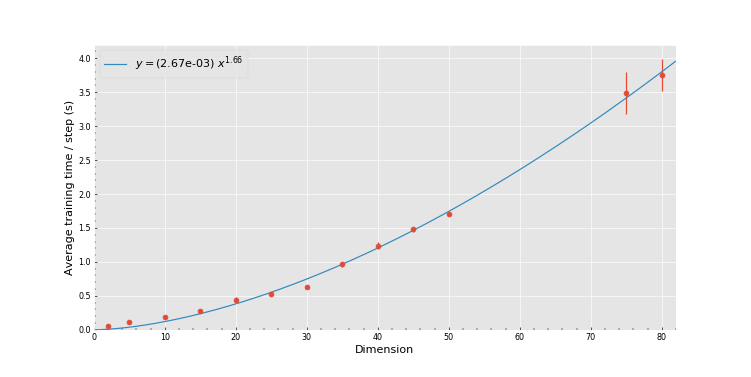

In [791]:
t = np.arange(0, 82, 0.1)
label_str = r'$y = $' + f'({a:.2e}) ' + r'$ x^{{{:.3g}}}$'.format(b)# + f' {c:.2g}'

fig, ax = plt.subplots()
i = 0
_ = ax.plot(t, func(t, *popt), ls='-', marker='', color='C1', label=label_str)
_ = ax.errorbar(tt_per_step_arr[:, 0], tt_per_step_arr[:, 1], 
                yerr=tt_per_step_arr[:, 2],
                color='C0', marker='o', ls='')#, fillstyle='')
#_ = ax.plot(t, 1.83E-03*t**2, color='C2', ls='-')
_ = ax.set_xlabel('Dimension', fontsize=14)
_ = ax.set_ylabel('Average training time / step (s)',fontsize=14)
_ = ax.legend(loc='best', fontsize=14)
_ = ax.set_xlim((0, 82))
_ = ax.set_ylim((0, 4.2))
fig.savefig('../../figures/training_time_vs_dimension_2dMOG.pdf', dpi=400, 
            bbox_inches='tight')
_ = plt.show()

In [746]:
# for y = A + B log(x)
B, A = np.polyfit(np.log(tt_per_step_arr[:,0]),
                  np.log(tt_per_step_arr[:,1]), 1)

In [781]:
from scipy.optimize import curve_fit

def func(x, a, b):#, c):
    return  a * (x ** b)# + c
    #return a * np.exp(-b * x) + c

x = tt_per_step_arr[:,0]
y = tt_per_step_arr[:,1]
popt, pcov = curve_fit(func, x, y)
a, b = popt
#a, b, c = popt
#yn = y + 0.2*np.random.normal(size=len(x))

In [760]:
popt

array([0.00182763, 1.74023556, 0.06950269])

# OLD

In [757]:
A, B

(-4.046610732195246, 1.1461409257473858)

In [754]:
x = np.arange(0, 82, 0.1)
y = np.exp(A/B) * (x ** B)

<IPython.core.display.Javascript object>


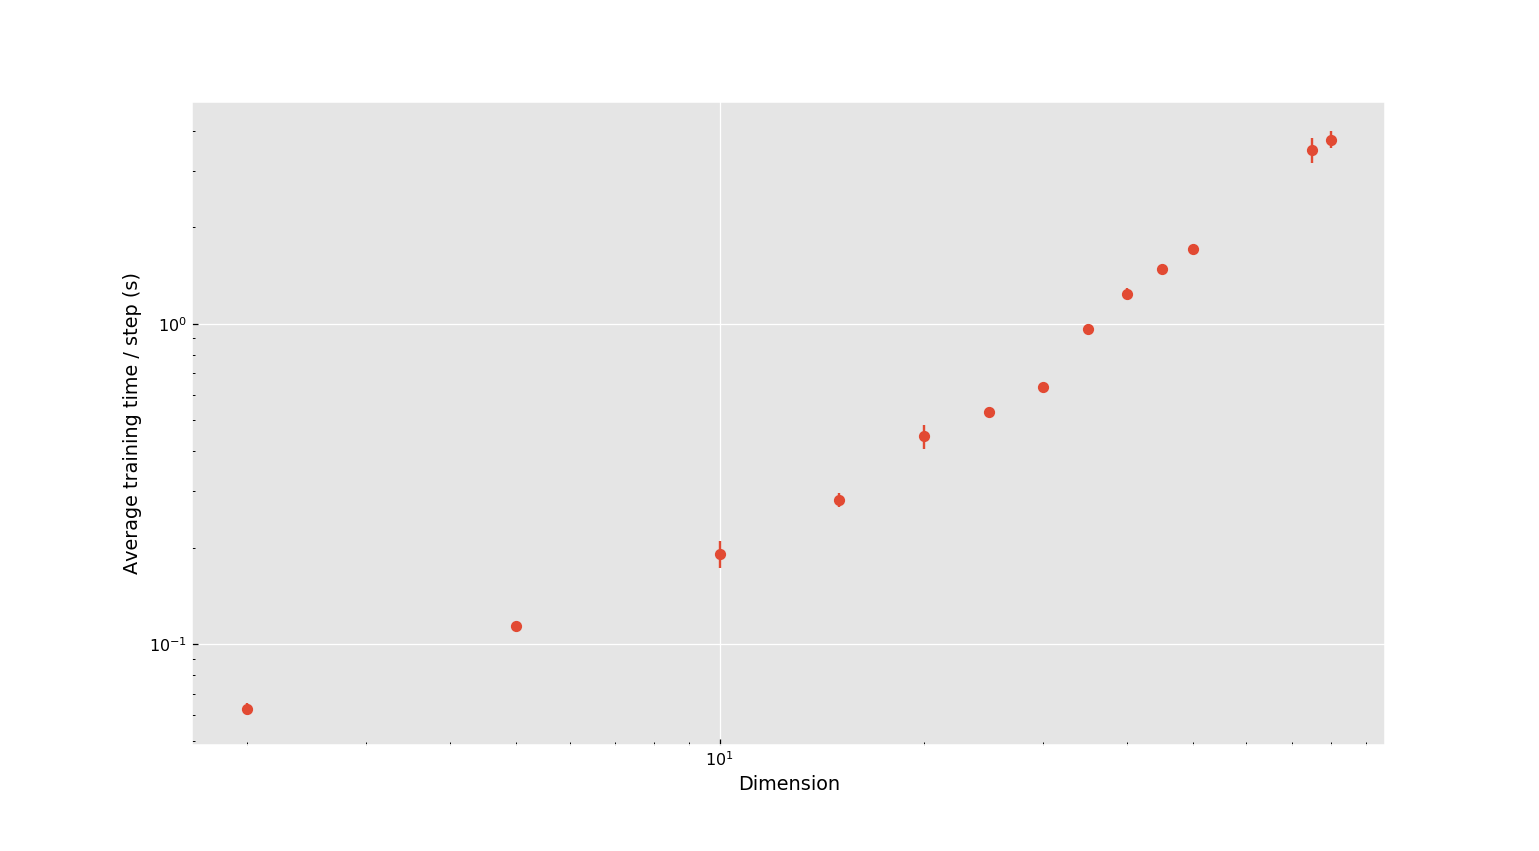

In [743]:
%matplotlib notebook
fig, ax = plt.subplots()
i = 0
_ = ax.errorbar(tt_per_step_arr[:, 0], tt_per_step_arr[:, 1], 
                yerr=tt_per_step_arr[:, 2],
                color='C0', marker='o', ls='')#, fillstyle='')

_ = ax.set_xlabel('Dimension')
_ = ax.set_ylabel('Average training time / step (s)')
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
_ = plt.show()

<IPython.core.display.Javascript object>


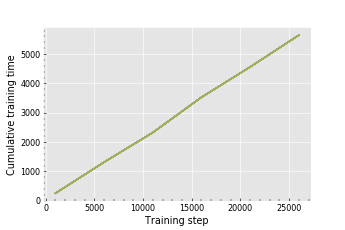

In [732]:
fig, ax = plt.subplots()
i = 0
for key, val in tt_diffs_dict.items():
    leg_label = 'dimension ' + key.split('_')[-1].lstrip('dim')
    _ = ax.plot(steps_arr[::5], t_diffs_arr[::5], 
            label=leg_label)
            #color=colors[i], marker=markers[i],
            #ls=linestyles[i], label=leg_label)
    i += 1
_ = ax.set_xlabel('Training step')
_ = ax.set_ylabel('Cumulative training time')
#ax.legend(loc='best')
plt.show()

In [735]:
tt_diffs_dict.keys()

odict_keys(['tt_dim2_339', 'tt_dim2_340', 'tt_dim5_384', 'tt_dim10_360', 'tt_dim10_359', 'tt_dim10_377', 'tt_dim15_379', 'tt_dim20_414', 'tt_dim20_386', 'tt_dim25_415', 'tt_dim25_387', 'tt_dim30_388', 'tt_dim30_416', 'tt_dim35_423', 'tt_dim35_421', 'tt_dim40_422', 'tt_dim45_419', 'tt_dim50_420', 'tt_dim75_429', 'tt_dim75_428'])

<IPython.core.display.Javascript object>


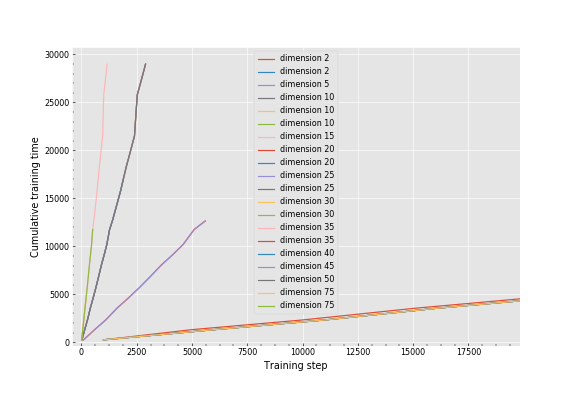

In [736]:
fig, ax = plt.subplots()
i = 0
for key, val in tt_diffs_dict.items():
    leg_label = 'dimension ' + key.split('_')[1].lstrip('dim')
    steps_arr, t_diffs_arr = split_dict(val)
    _ = ax.plot(steps_arr[::5], t_diffs_arr[::5], 
            label=leg_label)
            #color=colors[i], marker=markers[i],
            #ls=linestyles[i], label=leg_label)
    i += 1
_ = ax.set_xlabel('Training step')
_ = ax.set_ylabel('Cumulative training time')
ax.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


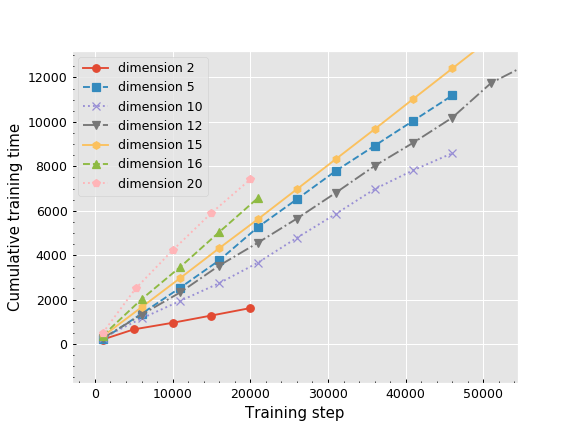

Text(0.5, 0, 'Training step')

Text(0, 0.5, 'Cumulative training time')

In [97]:
fig, ax = plt.subplots()
i = 0
for key, val in tt_diffs_dict.items():
    leg_label = 'dimension ' + key.split('_')[-1].lstrip('dim')
    steps_arr, t_diffs_arr = split_dict(val)
    ax.plot(steps_arr[::5], t_diffs_arr[::5], 
            color=colors[i], marker=markers[i],
            ls=linestyles[i], label=leg_label)
    i += 1
ax.set_xlabel('Training step')
ax.set_ylabel('Cumulative training time')
ax.legend(loc='best')
plt.show()

In [98]:
steps_dict = {}
for key, val in tt_diffs_dict.items():
    #leg_label = 'dimension ' + key.split('_')[-1].lstrip('dim')
    #steps_arr, t_diffs_arr = split_dict(val)
    steps_dict[key], _ = split_dict(val)

In [99]:
steps_dict

{'tt_dim2': array([ 1000,  1561,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
         9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,
        18000, 19000, 20000, 21000]),
 'tt_dim5': array([ 1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000,
        10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000,
        19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000,
        28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000,
        37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000,
        46000, 47000, 48000]),
 'tt_dim10': array([ 1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000,
        10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000,
        19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000,
        28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000,
        37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000,
        46000, 47000, 48000, 49000, 50000]),


## IGNORE

In [707]:
centers = 5
sigma = 1.
means = np.zeros((2,2))
means[::2, 0] = centers
means[1::2, 0] = - centers
cov_mtx = sigma * np.eye(2)
covs = np.array([cov_mtx] * 2)
pis = distribution_arr(2, 2)
distribution = GMM(means, covs, pis)

In [721]:
centers1 = 1
sigma1 = 0.05
means1 = np.zeros((2,2))
means1[::2, 0] = centers1
means1[1::2, 0] = - centers1
cov_mtx1 = sigma1 * np.eye(2)
covs1 = np.array([cov_mtx1] * 2)
pis1 = distribution_arr(2, 2)
distribution1 = GMM(means1, covs1, pis1)

In [723]:
samples = distribution.get_samples(200)
samples1 = distribution1.get_samples(200)

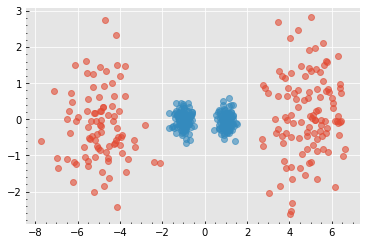

In [724]:
fig, ax = plt.subplots()
ax.plot(samples[:,0], samples[:,1], marker='o', ls='', alpha=0.6)
ax.plot(samples1[:,0], samples1[:,1], marker='o', ls='', alpha=0.6)
plt.show()